****
# Import modules
****

In [1]:
import os
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

****
# Load Data
****

In [2]:
file_path = "C:\\Users\\kruu\\store\\data_EDDM\\"

data_EDDM = pd.read_parquet(os.path.join(file_path + "landing_df_EDDM_with_meteo_0_of_9.parquet"))

for i in range(1, 10):
    temp = pd.read_parquet(os.path.join(file_path + f"landing_df_EDDM_with_meteo_{i}_of_9.parquet"))
    data_EDDM = pd.concat((data_EDDM, temp))

In [3]:
data_EDDM[["avg_wind_dir", "avg_wind_speed", "avg_vis", "avg_temp", "avg_press"]].isna().any()

avg_wind_dir       True
avg_wind_speed    False
avg_vis           False
avg_temp          False
avg_press         False
dtype: bool

In [3]:
# Redefine Rush hours as they were in UTC

def is_rush_hour(date): #based on hourly count bar plot: data_EDDM_reduced.groupby("hour").id.count().plot(kind="bar")
    
    # Extract hour
    hour = date.hour
    minute = date.minute
    time_in_minutes = hour * 60 + minute
    
    if (5 * 60 <= time_in_minutes <= 6 * 60) or \
       (7 * 60 <= time_in_minutes <= 9 * 60) or \
       (11 * 60 <= time_in_minutes <= 14 * 60) or \
       (16 * 60 <= time_in_minutes <= 20 * 60):
        return True
    else:
        return False

data_EDDM['rush_hour'] = data_EDDM["start"].apply(is_rush_hour)

In [4]:
data_EDDM["nominal_distance_prop"] = data_EDDM["distance"] / data_EDDM["nominal_distance"] 

****
# LR Model
****

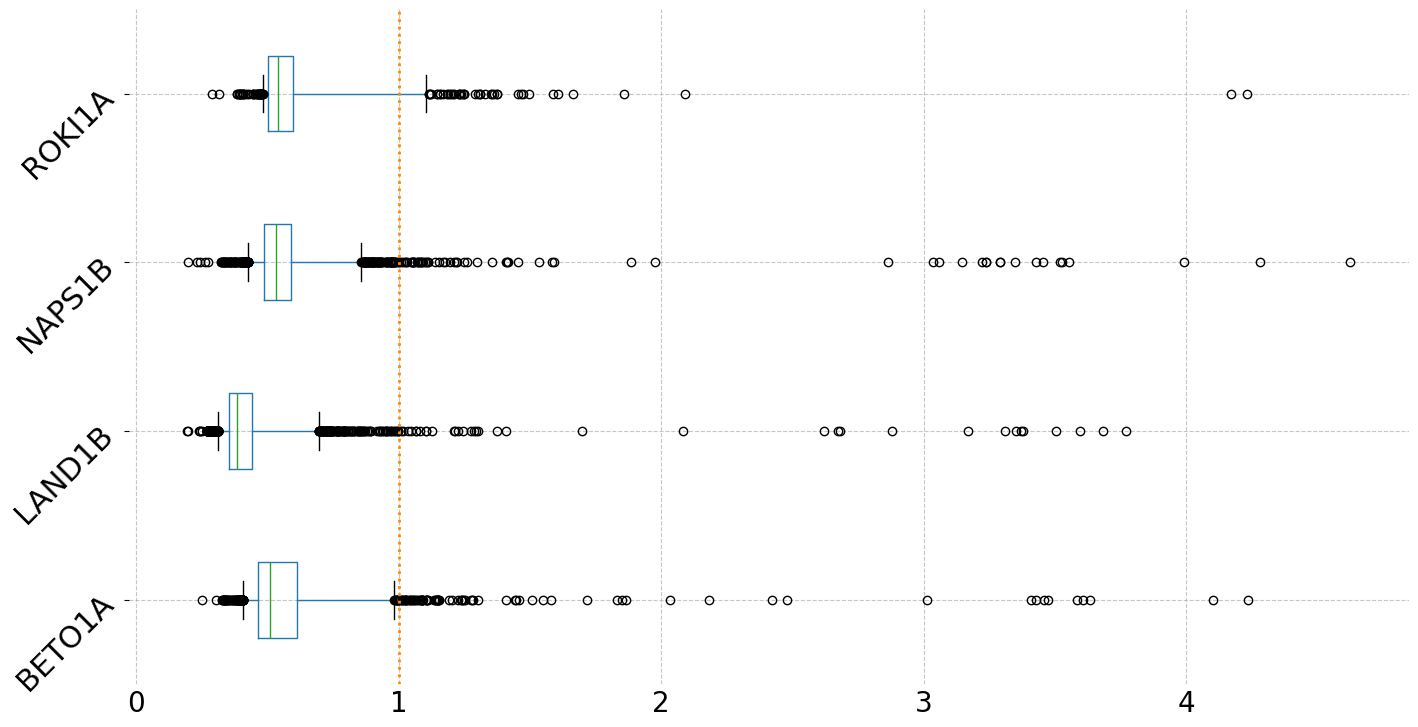

In [6]:
boxplot = data_EDDM.boxplot(["nominal_distance_prop"], by = ["star"],
                     figsize = (16, 9),
                     vert = False,
                     showmeans = False,
                     notch = False,
                     whis = (2.5,97.5))

boxplot.axvline(x=1, color='darkorange', linestyle=':', linewidth=2)

custom_labels = ['BETO1A', 'LAND1B', 'NAPS1B', 'ROKI1A'] #MAYBE IN WRONG ORDER
boxplot.set_yticklabels(custom_labels, fontsize=22, rotation=45)

boxplot.get_figure().suptitle('')
boxplot.set_ylabel("")
boxplot.set_title('')

boxplot.set_axisbelow(True)
boxplot.grid(True, linestyle='--', alpha=0.7)
boxplot.spines['top'].set_visible(False)
boxplot.spines['right'].set_visible(False)
boxplot.spines['left'].set_visible(False)
boxplot.spines['bottom'].set_visible(False)
boxplot.tick_params(axis='x', which='both', length=0, labelsize=20)

In [5]:
model_lm = smf.ols(
    "nominal_distance_prop ~ C(star) + C(weekday) + avg_vis + avg_wind_speed + C(season) + avg_vis + avg_press + C(body_type, Treatment(reference='Narrowbody')) + C(rush_hour) + avg_temp", 
    data_EDDM, 
)

res_lm = model_lm.fit()
res_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     nominal_distance_prop   R-squared:                       0.156
Model:                               OLS   Adj. R-squared:                  0.155
Method:                    Least Squares   F-statistic:                     179.4
Date:                   Tue, 01 Oct 2024   Prob (F-statistic):               0.00
Time:                           14:16:30   Log-Likelihood:                 4092.3
No. Observations:                  17526   AIC:                            -8147.
Df Residuals:                      17507   BIC:                            -7999.
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           0.7625      0.012     63.903      0.000       0.739       0.786
C(star)[T.LAND1B]                                                  -0.1468      0.004    -35.080      0.000      -0.155      -0.139
C(star)[T.NAPS1B]                                                  -0.0022      0.004     -0.500      0.617      -0.011       0.006
C(star)[T.ROKI1A]                                                   0.0303      0.006      5.241      0.000       0.019       0.042
C(weekday)[T.1]                                                    -0.0026      0.005     -0.474      0.635      -0.013       0.008
C(weekday)[T.2]                                                    -0.0143      0.005     -2.640      0.008      -0.025      -0.004
C(weekday)[T.3]                                                    -0.0059      0.005     -1.099      0.272      -0.016       0.005
C(weekday)[T.4]                                                    -0.0141      0.005     -2.611      0.009      -0.025      -0.004
C(weekday)[T.5]                                                    -0.0146      0.005     -2.667      0.008      -0.025      -0.004
C(weekday)[T.6]                                                    -0.0312      0.005     -5.741      0.000      -0.042      -0.021
C(season)[T.Spring]                                                -0.0181      0.004     -4.060      0.000      -0.027      -0.009
C(season)[T.Summer]                                                -0.0089      0.005     -1.697      0.090      -0.019       0.001
C(season)[T.Winter]                                                -0.0222      0.005     -4.487      0.000      -0.032      -0.013
C(body_type, Treatment(reference='Narrowbody'))[T.Regional Jet]     0.0018      0.003      0.550      0.582      -0.005       0.008
C(rush_hour)[T.True]                                                0.0250      0.003      7.353      0.000       0.018       0.032
avg_vis                                                            -0.0233      0.001    -18.713      0.000      -0.026      -0.021
avg_wind_speed                                                      0.0018      0.000      4.528      0.000       0.001       0.003
avg_press                                                          -0.0003      0.000     -1.349      0.177      -0.001       0.000
avg_temp                                                            0.0016      0.000      4.721      0.000       0.001       0.002
==============================================================================
Omnibus:                    27322.599   Durbin-Watson:             

In [8]:
res_lm.save("res_lr_eddm.pkl")

C:\Users\kruu\AppData\Local\Temp\ipykernel_12968\93247352.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = significance_stars(p_values[indices][i])
C:\Users\kruu\AppData\Local\Temp\ipykernel_12968\93247352.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if p_values[indices][i] < 0.05:
C:\Users\kruu\AppData\Local\Temp\ipykernel_12968\93247352.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if p_values[indices][

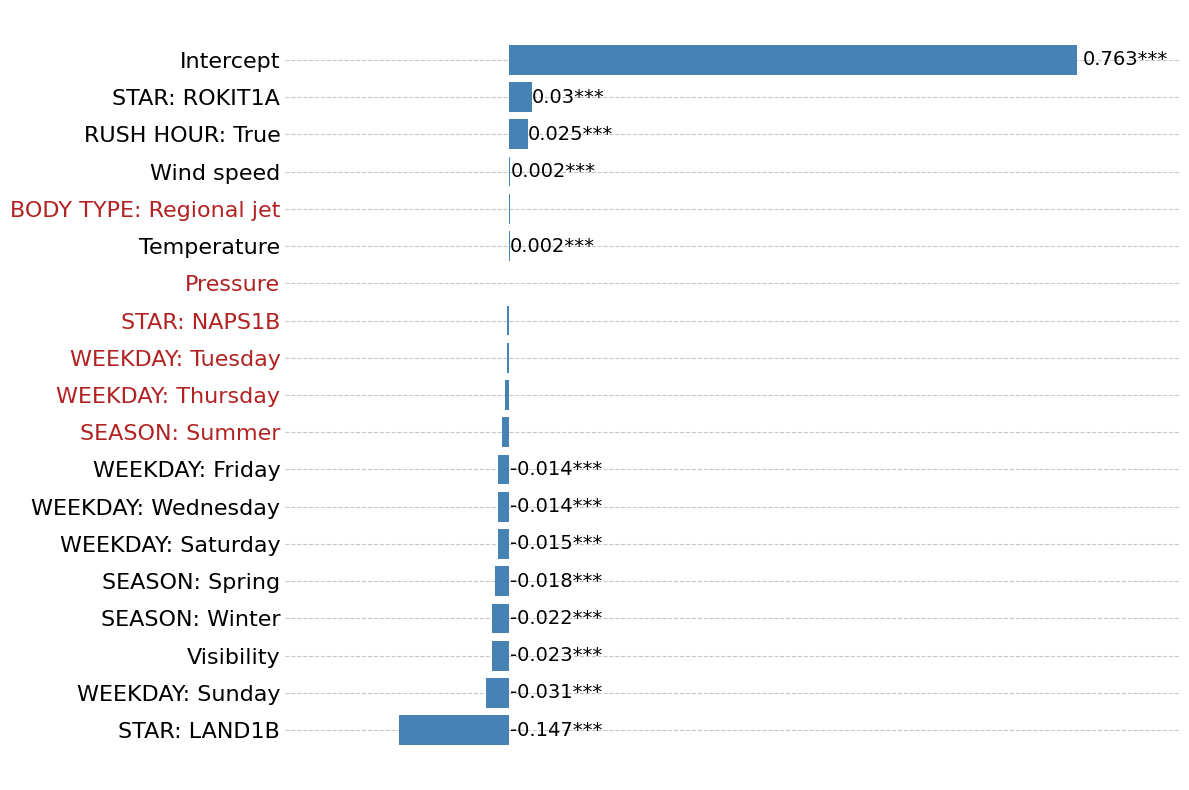

In [6]:
import matplotlib.pyplot as plt
import numpy as np

coefficients = res_lm.params
p_values = res_lm.pvalues

# features = coefficients.index  # Feature names
features = np.array([ #Same order as coefficients.index 
    "Intercept", 
    "STAR: LAND1B",
    "STAR: NAPS1B",
    "STAR: ROKIT1A",
    "WEEKDAY: Tuesday",
    "WEEKDAY: Wednesday",
    "WEEKDAY: Thursday",
    "WEEKDAY: Friday",
    "WEEKDAY: Saturday",
    "WEEKDAY: Sunday",
    "SEASON: Spring",
    "SEASON: Summer",
    "SEASON: Winter",
    "BODY TYPE: Regional jet",
    "RUSH HOUR: True",
    "Visibility",
    "Wind speed",
    "Pressure",
    "Temperature",
])
importance = coefficients.values  # Absolute coefficients to represent feature importance

indices = np.argsort(importance)

bar_color = 'steelblue'

def significance_stars(p_value):
    if p_value <= 0.01:
        return '***'
    elif p_value <= 0.05:
        return '**'
    elif p_value <= 0.10:
        return '*'
    else:
        return ''

plt.figure(figsize=(12, 8))
plt.barh(range(len(importance)), importance[indices], align='center', color=bar_color)

for i in range(len(importance)):
    pvalue = significance_stars(p_values[indices][i])
    if p_values[indices][i] < 0.05: 
        if importance[indices][i] > 0:
            plt.text(importance[indices][i] * 1.01, i, f'{np.round(importance[indices][i],3)}{pvalue}', va='center', fontsize=14)
        else:
            plt.text(0.001, i, f'{np.round(importance[indices][i],3)}{pvalue}', va='center', fontsize=14)
        

y_labels = plt.yticks(range(len(importance)), features[indices], fontsize=16)
for i in range(len(importance)):
    if p_values[indices][i] > 0.05:
        y_labels[1][i].set_color('firebrick')

ax = plt.gca()
ax.set_xlim(-0.3, 0.9)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='y', which='both', length=0)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.xlabel('')
plt.title('')
plt.tight_layout()
plt.show()